# Сборный проект №2

<b>Описание проекта:</b>

Перед нами данные, предоставленные стартапом, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

В частности нам предстоит изучить воронку продаж и выяснить как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. И какие именно это шаги.

Далее исследуем результаты А/А/В эксперимента по введению новых шрифтов в приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

<b>Описание данных:</b>

Каждая запись в логе — это действие пользователя, или событие.   
1. EventName — название события;
2. DeviceIDHash — уникальный идентификатор пользователя;
3. EventTimestamp — время события
4. ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

###  Выгрузим данные.

In [3]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [4]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Подготовка данных

Изменим названия столбцов, тип данных где это необходимо и проверим данные на дупликаты.

In [6]:
data.columns = ['event_name', 'user_id', 'datetime', 'group']
data['datetime'] = pd.to_datetime(data['datetime'], unit='s')
data['date'] = data['datetime'].dt.strftime('%Y-%m-%d')

In [7]:
data.head()

,event_name,user_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [8]:
print(np.round(data.duplicated().sum() / data.shape[0] * 100, 2))
data = data.drop_duplicates().reset_index(drop=True)

0.17


Количество дубликатов составляет 0.17% от общего числа записей, смело их удаляем.

### Изучение и проверка данных

In [9]:
print('Общее количество событий в логе:', 
      data['event_name'].count())
print('Количество уникальных событий в логе:',
      data['event_name'].nunique())
print('Количество уникальных пользователей в логе:',
      data['user_id'].nunique())
print('Среднее арифметическое количества событий на пользователя:',
      np.round(data['event_name'].count() / data['user_id'].nunique(), 2))
print('Медиана количества событий на пользователя:',
      data.groupby('user_id')['event_name'].agg('count').median())

Общее количество событий в логе: 243713
Количество уникальных событий в логе: 5
Количество уникальных пользователей в логе: 7551
Среднее арифметическое количества событий на пользователя: 32.28
Медиана количества событий на пользователя: 20.0


In [10]:
print('Период данных составляет с {} по {}'
      .format(data['datetime'].min(), data['datetime'].max()),
       'или', data['datetime'].max() - data['datetime'].min())

Период данных составляет с 2019-07-25 04:43:36 по 2019-08-07 21:15:17 или 13 days 16:31:41


Построим гистограмму, за шаг возьмем 1 час:

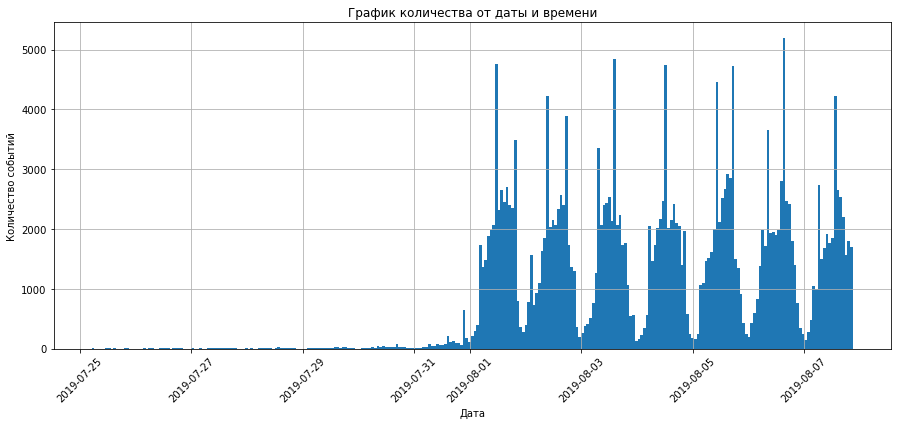

In [11]:
dt_in_hours = data['datetime'].dt.round('h')

plt.figure(figsize=(15, 6))
plt.hist(dt_in_hours, bins = dt_in_hours.nunique())
plt.xticks(rotation=45)
plt.grid()
plt.title('График количества от даты и времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата');

Рассмотрим внимательнее начало периода активности:

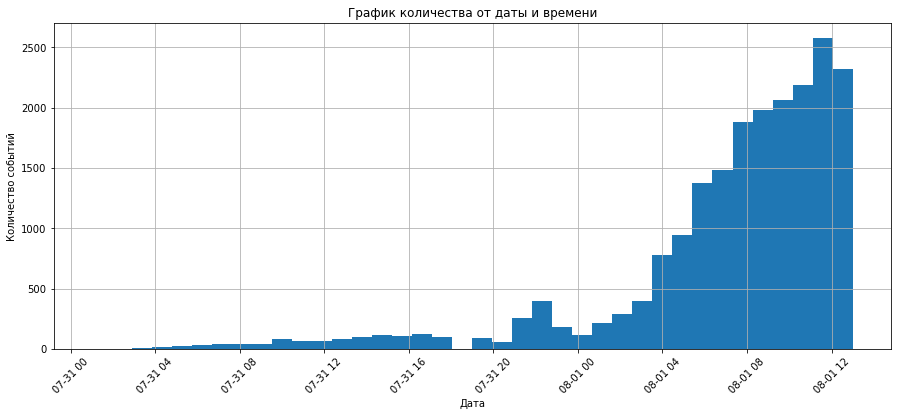

In [12]:
plt.figure(figsize=(15, 6))
plt.hist(dt_in_hours[lambda x: (x > '2019-07-31 00:00:00') & (x < '2019-08-01 14:00:00')],
         bins = 38)
plt.xticks(rotation=45)
plt.grid()
plt.title('График количества от даты и времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата');

Глядя на первый график можно сказать, что реально мы располагаем данными за первые 7 дней августа (данные в июле ничтожно малы). Также можно отметить, что распределение событий в августе идет циклично - с утра количество событий нарастает, а к вечеру - падает.
Можно предположить, что малое количество данных в начале периода обусловлены тестовым режимом или неправильным методом сбора. Для корректного анализа удалим данные за июль, возможно, данные начали правильно собирать именно с полуночи, такая граница является психологически логичной. 

In [13]:
df = data.loc[data['datetime'] >= '2019-08-01 00:00:00'].reset_index(drop=True)

Теперь необходимо проверить, много ли мы отсекли. Проверим, сколько потерялось событий и пользователей.

In [14]:
print('Процент потерянных пользователей:',
      np.round((data['user_id'].nunique() -  df['user_id'].nunique()) 
      / data['user_id'].nunique() * 100, 2))

Процент потерянных пользователей: 0.23


In [15]:
print('Процент потерянных событий:',
    np.round((data['event_name'].count() - df['event_name'].count()) 
    / data['event_name'].count() * 100, 2))

Процент потерянных событий: 1.16


Всего 0.23% пользователей и 1.16% событий, величины статистически не значимы.

Проверим, что в данных присутствуют пользователи из всех трёх экспериментальных групп.

In [16]:
df.groupby('group').agg('count')['user_id']

group
246    79302
247    77022
248    84563
Name: user_id, dtype: int64

In [17]:
df.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Все в порядке, и количество пользователей в каждой группе примерно равное.

<b>Вывод:</b> Мы ответили на вопросы и получили следующие результаты:

Нашли общее количество событий, уникальное количество событий и количество уникальный пользователей.
В среднем событий на пользователя (медианное значение): 20
Построили гисторгамму по дате и времени.
Определили необходимы промежуток данных для анализа: с 01.08.2022.

После очистки данных мы потеряли около 1% событий и меньше процента пользователей.
Проверили, что у нас есть пользователи из всех трёх экспериментальных групп.

### Изучаем воронку событий.

Посмотрим, какие события есть в логах и как часто они встречаются.

In [18]:
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали каждое событие.

In [19]:
events_by_users = (df.groupby('event_name')
                  .agg({'event_name':'count', 'user_id':'nunique'})
                  .sort_values(by='user_id', ascending=False))

events_by_users.columns = ['count', 'users']

events_by_users = events_by_users.reset_index()

events_by_users['percent'] = np.round(
    events_by_users['users'] / df['user_id'].nunique() * 100, 2)

events_by_users

,event_name,count,users,percent
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


In [53]:
#fig = go.Figure(data=[go.Pie(labels=df['event_name'].value_counts().index,
#                             values=df['event_name'].value_counts(), 
#                             title='Доли событий')])
#fig.show()

# так как гитхаб не поддерживает графики plotly, выгрузил график картинкой

from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url= "https://downloader.disk.yandex.ru/preview/58d4e0da9bcd06d1e1005a149d33fed9e46b328b5173acc4fc1fe96b7888f4cd/643027ab/OELJ15SCdSg4ZMFoLlCzjXB8bpFQ1TKYL5tcI-9UCrnWwMPN2kQKmyhYCguPwbrbxqaAZR8MTEHNsZ3qCILrUw%3D%3D?uid=0&filename=newplot3.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048"))

Подсчитав частоту каждого события, можно предположить их следующий порядок:
1. MainScreenAppear - Появление Главного экрана - Зашли на сайт
2. OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу
3. CartScreenAppear - Появление Экрана Корзины - Добавили в корзину
4. PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили
5. Tutorial - Руководство пользователя - Изучали инструкцию

Цепочка выглядит логичной, например, нельзя оплатить товар, не добавив в корзину. Пункт Tutorial хоть и был добавлен в конец, как пункт с самим низким показателем, но пользователь мог изучить руководство в любой момент во время взаимодействия приложения. В дальнейшем, этот пункт мы опустим в исследованиях.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

Построим наглядный график, пользуясь библиотекой:

In [52]:
#fig = go.Figure(go.Funnel(x = events_by_users['users'], 
#                          y = events_by_users['event_name'], 
#                          textinfo = "value+percent initial+percent previous"))
#fig.update_layout(title_text='Воронка событий', title_x=0.55)
#fig.show();

display(Image(url= "https://downloader.disk.yandex.ru/preview/991b83747a810b59f59cb0ed0a78c69ad531af02f8e52c418b22032f4e806159/643026e0/FYy86ba1aY1zAjgQ3gahQ8lQutFFPo9jtZsPSZe9lEWws81wWwDKEFubK9tfXNmqpIJPc74_XR3cHQ1JnvBc0Q%3D%3D?uid=0&filename=newplot2.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048"))

Теперь создадим таблицу вручную:

In [22]:
prev_users = events_by_users.loc[0,'users']
start_users = prev_users

for i in events_by_users.index:
    events_by_users.loc[i,'from_previous'] = np.round(events_by_users.loc[i,'users'] /
                                                      prev_users * 100, 2)
    events_by_users.loc[i,'from_start'] = np.round(events_by_users.loc[i,'users'] /
                                                   start_users * 100, 2)
    prev_users = events_by_users.loc[i,'users']
events_by_users

,event_name,count,users,percent,from_previous,from_start
0,MainScreenAppear,117328,7419,98.47,100.00,100.00
1,OffersScreenAppear,46333,4593,60.96,61.91,61.91
2,CartScreenAppear,42303,3734,49.56,81.30,50.33
3,PaymentScreenSuccessful,33918,3539,46.97,94.78,47.70
4,Tutorial,1005,840,11.15,23.74,11.32


Теперь "честно" проследим, как с учетом предполагаемой цепочки на самом деле меняется процент перешедших с предыдущего шага, для этого отследим пользователей, который прошли все этапы. 

In [23]:
users = df[df['event_name'] != 'Tutorial'].pivot_table(
        index=['user_id'], 
        columns='event_name', 
        values='datetime',
        aggfunc='min').reset_index()

In [24]:
step_1 = (~users['MainScreenAppear'].isna())
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

In [25]:
true_events =[]
true_events.append(users[step_1].shape[0])
true_events.append(users[step_2].shape[0])
true_events.append(users[step_3].shape[0])
true_events.append(users[step_4].shape[0])

In [48]:
#fig = go.Figure(go.Funnel(
#    y = events_by_users['event_name'],
#    x = true_events,
#    hoverinfo = 'x + percent initial',
#    textinfo = 'value+percent initial'
#    ))
#fig.update_layout(title_text='Последовательная воронка событий', title_x=0.55)
#fig.show()

display(Image(url= "https://downloader.disk.yandex.ru/preview/4fdfac91a7f9be7b74ab2a141244a1ea03b6facdb85310edd980e8c5ff2be379/643023d6/pdh6LSGSZC3IDkEtBlCXV2-9NLpTQGPCqDvZtzbqBwfO7brRhIuexRhhAzOpvBThZDv_qFdkijoL6pA6C1bPGA%3D%3D?uid=0&filename=newplot.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048"))

Доля пользователей, которая доходит от первого события до оплаты, составляет всего 6%. Низкий показатель, но зато. реалистичный


<b>Вывод:</b> Из первой воронки видно, что очень много (38%) пользователей не попадают даже на второй экран (OffersScreenAppear) с выбором товара. Возможно есть какая-то проблема на первом экране (MainScreenAppear), которая мешает, усложняет, отпугивает пользователей - надо об этом сообщить менеджменту и обязательно выснить причину. Если рассматривать события последовательно, также больше всего пользователей теряется на этом шаге. Скорее всего, дело в дизайне или неудобном иинтерфейсе.

### Изучаем результаты эксперимента

Для начала, проверим, сколько пользователей в каждой экспериментальной группе и заменим числа на более удобные обозначения.

In [27]:
def rename_group(gr):
    if gr==246:
        return 'A1'
    elif gr==247:
        return 'A2'
    elif gr==248:
        return 'B'
    else:
        return 'ERROR'

df['group'] = df['group'].apply(rename_group)

In [28]:
for g in df['group'].unique():
    print(f"В группе '{g}' - {df[df['group']==g]['user_id'].nunique()} пользователей")

В группе 'A1' - 2484 пользователей
В группе 'A2' - 2513 пользователей
В группе 'B' - 2537 пользователей


Проверим, что пользователи в группах не пересекаются:

In [29]:
false_users = list(df.groupby('user_id')
             .nunique()
             .query('group != 1')
             .index)
false_users

[]

Отлично, повторов пользователей нет.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [30]:
users_by_group = df[df['event_name'] != 'Tutorial'].groupby('group')['user_id'].nunique()
users_by_group['AA'] = users_by_group['A1'] + users_by_group['A2']

group_test = df[df['event_name'] != 'Tutorial'].pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False).reset_index()


group_test['AA'] = group_test['A1'] + group_test['A2']
group_test['all'] = group_test['AA'] + group_test['B']

group_test['part_A1'] = np.round(group_test['A1'] / users_by_group['A1'] * 100, 2)
group_test['part_A2'] = np.round(group_test['A2'] / users_by_group['A2'] * 100, 2)
group_test['part_B'] = np.round(group_test['B'] / users_by_group['B'] * 100, 2)
group_test['part_AA'] = np.round((group_test['A1'] + group_test['A2']) / 
                                  (users_by_group['A1'] + users_by_group['A2']) * 100, 2)

group_test

group,event_name,A1,A2,B,AA,all,part_A1,part_A2,part_B,part_AA
0,MainScreenAppear,2450,2476,2493,4926,7419,98.67,98.57,98.34,98.62
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.10,60.51,60.39,61.30
2,CartScreenAppear,1266,1238,1230,2504,3734,50.99,49.28,48.52,50.13
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.33,46.10,46.59,47.21


Для статистического анализа напишем функцию "z_test" для проведения тестов, аргументами будут 3 параметра: первая группа, вторая группа, уровень статистической значимости. Затем проведем тесты между группами, во всех случаях гипотезы будут звучать так: H₀ - статистически значимых различий в конверсии между долями нет, альтернативная гипотеза H₁ - статистически значимые различия в конверсии между долями есть.

In [31]:
all_p_values = []
def z_test(group1, group2, alpha):
    
    for i in group_test.index:
        
        p1 = group_test[group1][i] / users_by_group[group1]
        p2 = group_test[group2][i] / users_by_group[group2]
        p_combined = ((group_test[group1][i] + group_test[group2][i]) / 
                      (users_by_group[group1] + users_by_group[group2]))
        difference = p1 - p2
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_by_group[group1] + 1/users_by_group[group2]))
        
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('{} p-значение: {}'.format(group_test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        all_p_values.append(p_value)

In [32]:
z_test("A1", "A2", 0.01)

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



В данном случае уровень статистической значимости установлен как 0.01, так как A/A тест требует  высокой точности. В остальных случаях ограничимся 0.05. 
Так как доли статистически равные, обе группы можно считать контрольными.

In [33]:
z_test("A1", "B", 0.05)

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [34]:
z_test("A2", "B", 0.05)

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [35]:
z_test("AA", "B", 0.05)

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Так как нам пришлось столкнуться с многократными проверками, воспользуемся поправкой Бонферрони:

In [36]:
from statsmodels.sandbox.stats.multicomp import multipletests
for i in range(4):
    print(group_test['event_name'][i])
    print(multipletests(all_p_values[i::4], method='bonferroni', alpha=0.05)[0])

MainScreenAppear
[False False False False]
OffersScreenAppear
[False False False False]
CartScreenAppear
[False False False False]
PaymentScreenSuccessful
[False False False False]


Значения False означают, что гипотеза не может быть отвергнута, соответственно, для всех случаев подтверждаются результаты предыдущих тестов

<b>Вывод:</b> Нами разработана функция, которая проводит статистический анализ. Проверены контрольные группы на А/А тесте. Тесты показали, что статистической разницы между долями группы В и А1, А2 нет. Сравнение результатов с объединенной контрольной группой также не показало значимой разницы.

### Итоговые выводы

Анализируя данные и результаты A/A/B-эксперимента можно сделать следующие выводы:

1. В исходном файле содержаться ненужные данные, было принято решение анализировать только августовские показатели.
2. От первого события до оплаты доходит меньше половины пользователей, и эту проблему необходимо анализировать отдельно, необходима работа с другими отделами. Меньше всего пользователи находятся на этапе с ознакомлением с руководством.
3.Были проверены статистические гипотезы с уровнем значимости 0.05 и ни одна из них не выявила значимой разницы. Были проверены контрольные группы с тестом с уровнем значимости 0.01. Ни один тест не выявил статистической разницы в конверсии

Исходя из результатов данного A/A/B-эксперимента, мы можем судить, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Что можно считать успехом, т.к. целью было узнать не отпугнут ли изменения пользователей. В то же время учитывая результаты эксперимента, если изменение шрифта не продиктовано проблемами в работе приложения, его можно не менять.